In [2]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import LinearSVR
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import mutual_info_regression
from category_encoders import MEstimateEncoder
from sklearn.metrics import mean_absolute_error
from sklearn.svm import SVR
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)

In [3]:
data = pd.read_csv('./data.csv')

In [4]:
#Feature importance
def calculate_mi_score(data_frame,target_var):
    data_frame = data_frame.copy()
    for colname in data_frame.select_dtypes(['object','category']):
        data_frame[colname], _ = data_frame[colname].factorize()
        
    discrete_features = [pd.api.types.is_integer_dtype(t) for t in data_frame.dtypes]
    mi_score = mutual_info_regression(data_frame,target_var,discrete_features=discrete_features,random_state=0)
    mi_score = pd.Series(mi_score,name='Mutual Information Score',index=data_frame.columns)
    mi_score = mi_score.sort_values(ascending=False)
    return mi_score


In [5]:
calculate_mi_score(data.drop(['price'], axis='columns'), data.price)

street           1.149118
statezip         0.457778
city             0.310472
sqft_living      0.298258
sqft_above       0.200071
bathrooms        0.193590
sqft_lot         0.144439
bedrooms         0.076253
yr_built         0.075571
floors           0.071026
view             0.052216
sqft_basement    0.044597
yr_renovated     0.018178
condition        0.006858
waterfront       0.005099
date             0.004385
country          0.000000
Name: Mutual Information Score, dtype: float64

In [6]:
#data preprocessing
data.drop(['condition', 'waterfront', 'date', 'country'], axis='columns', inplace=True)

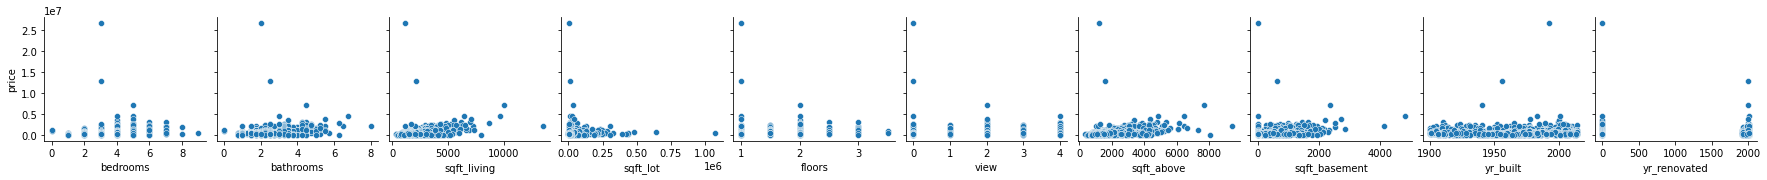

In [7]:
plot = sns.pairplot(data, 
                    y_vars=['price'],
                    x_vars=data.drop(['price', 'street', 'city', 'statezip'], axis='columns'),
                    height=2.5)

In [8]:
data.price.describe()

count    4.600000e+03
mean     5.519630e+05
std      5.638347e+05
min      0.000000e+00
25%      3.228750e+05
50%      4.609435e+05
75%      6.549625e+05
max      2.659000e+07
Name: price, dtype: float64

In [9]:
for i in range(3):
    data = data[data.price != max(data.price.values)]

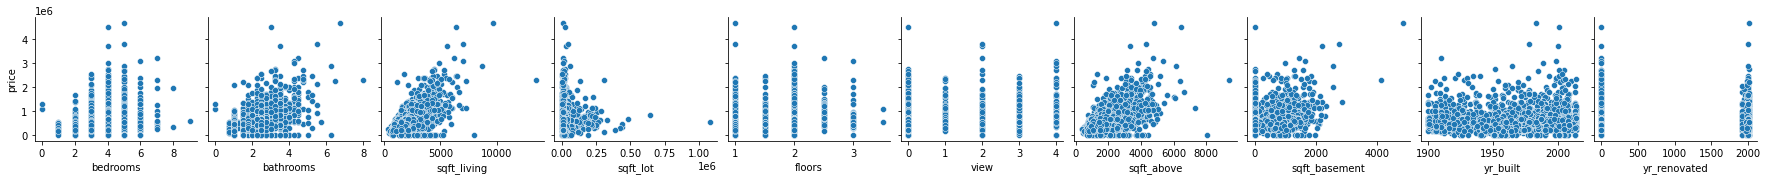

In [10]:
plot = sns.pairplot(data, 
                    y_vars=['price'],
                    x_vars=data.drop(['price', 'street', 'city', 'statezip'], axis='columns'),
                    height=2.5)

In [11]:
data.price.describe()

count    4.597000e+03
mean     5.421967e+05
std      3.579301e+05
min      0.000000e+00
25%      3.225000e+05
50%      4.600000e+05
75%      6.530000e+05
max      4.668000e+06
Name: price, dtype: float64

In [12]:
X = data.drop(['price'], axis='columns')
y = data.price

In [13]:
encoder = MEstimateEncoder(cols=['street', 'statezip', 'city'], m=0.5)
encoder.fit(X, y)
X = encoder.transform(X)

In [14]:
#Train test splitting
X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, test_size=0.20)

In [15]:
#Model creation
#model = RandomForestRegressor(n_estimators=1000)
#model = LinearRegression()
model = LinearSVR(max_iter=10000)
#model = SVR(kernel='linear') 
model.fit(X_train, y_train)
scores = cross_val_score(model, X_train, y_train, cv=10)

In [16]:
model.score(X_test, y_test)

0.9978375788489772

In [17]:
model.score(X_train, y_train)

0.9793349605306402

In [18]:
sum(scores)/len(scores)

0.9845611510478575

In [19]:
scores1 = cross_val_score(model, X_test, y_test , cv=10)
sum(scores1)/len(scores1)

0.9977767276906885

In [20]:
mean_absolute_error(y_test, model.predict(X_test))

8268.107762243568

In [21]:
from sklearn.metrics import r2_score
r2_score(y_test, model.predict(X_test))

0.9978375788489772

In [22]:
from sklearn.metrics import mean_squared_error
mean_squared_error(y_test, model.predict(X_test))

252304311.19660246

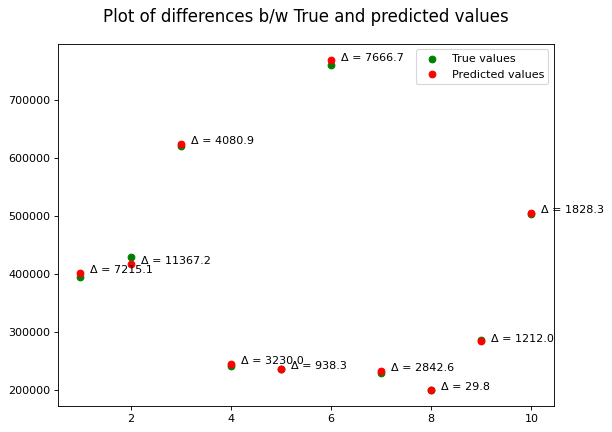

In [48]:
from matplotlib.pyplot import figure
figure(figsize=(8,6), dpi=80)
true_vals = np.array(y_test[:10])
predicted = np.array(model.predict(X_test)[:10])
X = range(1, 10+1)
plt.scatter(X, true_vals, color='green', label='True values')
plt.scatter(X, predicted, color='red', label='Predicted values')
differences = abs(true_vals-predicted)
differences = [round(i, 1) for i in differences]
for i, label in enumerate(differences):
    plt.annotate('Δ = {}'.format(label), (X[i]+0.20, predicted[i]+0.05))
plt.title('Plot of differences b/w True and predicted values', fontsize=15, pad=20)
plt.legend()